# **Spin** calculation

IDEA:
- take in consideration only the ball for each frame
- draw a lot of points on the ball
- take the motion of these points between consecutive frames (optical flow)
- from this motion we extract the direction of the rotation and so the axis of rotation

In [10]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from pathlib import Path
from IPython.display import clear_output, display

In [11]:
VIDEO_NUMBER = "3"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{VIDEO_NUMBER}" / f"Recording_{VIDEO_NUMBER}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{VIDEO_NUMBER}.csv")

In [12]:
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
if not cap.isOpened():
    raise IOError("Error: Could not open video.")
df = pd.read_csv(INPUT_CSV_PATH)
if df.empty:
    raise ValueError("Error: The CSV file is empty.")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_idx = 0

# Read first frame
ret, prev_frame = cap.read()
if not ret:
    print("Cannot read first frame.")

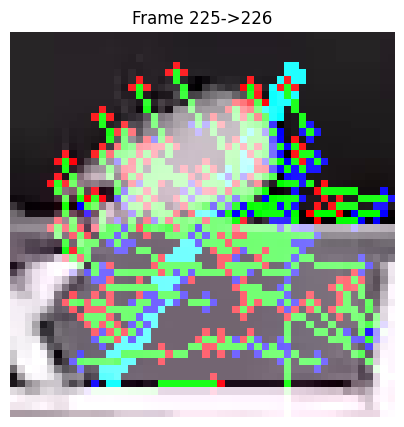

End of video or cannot read frame.
Done.


In [13]:
while True:
    # Read next frame
    ret, curr_frame = cap.read()
    if not ret:
        print("End of video or cannot read frame.")
        break

    # Retrieve detection for this frame_idx
    if frame_idx >= len(df):
        print(f"No CSV entry for frame {frame_idx}, skipping.")
        prev_frame = curr_frame
        frame_idx += 1
        continue
    df_row = df.iloc[frame_idx]
    if pd.isna(df_row['x']) or pd.isna(df_row['y']) or pd.isna(df_row['radius']):
        print(f"Missing detection at frame {frame_idx}, skipping.")
        prev_frame = curr_frame
        frame_idx += 1
        continue

    # Ball parameters
    ball_center = np.array([int(df_row['x']), int(df_row['y'])])
    ball_radius = int(df_row['radius'])

    # Define ROI bounds
    offset = 2
    x_min = max(ball_center[0] - ball_radius - offset, 0)
    x_max = min(ball_center[0] + ball_radius + offset, prev_frame.shape[1])
    y_min = max(ball_center[1] - ball_radius - offset, 0)
    y_max = min(ball_center[1] + ball_radius + offset, prev_frame.shape[0])

    # Crop and convert
    oi1 = prev_frame[y_min:y_max, x_min:x_max]
    oi2 = curr_frame[y_min:y_max, x_min:x_max]
    gray1 = cv2.cvtColor(oi1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(oi2, cv2.COLOR_BGR2GRAY)

    # Center in ROI coords
    center_roi = np.array([ball_center[0] - x_min, ball_center[1] - y_min])

    # Sample 100 points inside circle
    h, w = gray1.shape
    pts = []
    while len(pts) < 100:
        x, y = np.random.randint(0, w), np.random.randint(0, h)
        if (x - center_roi[0])**2 + (y - center_roi[1])**2 <= (ball_radius-2)**2:
            pts.append([x, y])
    p0 = np.array(pts, dtype=np.float32).reshape(-1,1,2)

    # Optical flow
    p1, status, _ = cv2.calcOpticalFlowPyrLK(
        gray1, gray2, p0, None,
        winSize=(15,15), maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    # Lift to 3D
    old3d, new3d = [], []
    for o, n, s in zip(p0.reshape(-1,2), p1.reshape(-1,2), status.reshape(-1)):
        if s == 1:
            ox, oy = o - center_roi
            nx, ny = n - center_roi
            oz = np.sqrt(max(ball_radius**2 - ox**2 - oy**2, 0))
            nz = np.sqrt(max(ball_radius**2 - nx**2 - ny**2, 0))
            old3d.append([ox, oy, oz])
            new3d.append([nx, ny, nz])
    old3d, new3d = np.array(old3d), np.array(new3d)

    if len(old3d) < 3:
        print(f"Insufficient points at frame {frame_idx}, skipping axis.")
        prev_frame = curr_frame
        frame_idx += 1
        continue

    # Kabsch
    H = old3d.T @ new3d
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    theta = np.arccos((np.trace(R) - 1) / 2)
    axis = np.array([R[2,1] - R[1,2], R[0,2] - R[2,0], R[1,0] - R[0,1]])
    axis /= (2 * np.sin(theta))
    axis /= np.linalg.norm(axis)

    # Visualization mask
    mask = np.zeros_like(oi2)
    if axis[2] != 0:
        a2 = axis[:2] / np.linalg.norm(axis[:2])
        pA = (center_roi + a2 * ball_radius).astype(int)
        pB = (center_roi - a2 * ball_radius).astype(int)
        cv2.line(mask, tuple(pA), tuple(pB), (255,255,0), 2)
    for o, n, s in zip(p0.reshape(-1,2), p1.reshape(-1,2), status.reshape(-1)):
        if s == 1:
            oc, nc = tuple(o.astype(int)), tuple(n.astype(int))
            cv2.circle(mask, oc, 1, (0,0,255), -1)
            cv2.circle(mask, nc, 1, (255,0,0), -1)
            cv2.line(mask, oc, nc, (0, 255, 0), 1)

    over = cv2.addWeighted(oi2, 1, mask, 1, 0)
    rgb = cv2.cvtColor(over, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.figure(figsize=(5,5))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(f'Frame {frame_idx}->{frame_idx+1}')
    display(plt.gcf())
    plt.close()
    time.sleep(1/fps)

    prev_frame = curr_frame
    frame_idx += 1

cap.release()
print("Done.")